In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
from scipy.stats import entropy
from PIL import Image
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import os
import torch.nn as nn
import torch
import torch.optim as optim
import torch
from PIL import Image
import numpy as np
import os

In [2]:
class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()
        # Load the pre-trained ResNet model and use it as the encoder
        resnet = models.resnet18(pretrained=None)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove the fully connected layer and avgpool
        # Decoder part
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # To ensure the output is between 0 and 1
        )

    def forward(self, x):
        # Encode the input
        encoded = self.encoder(x)
        # Decode to reconstruct the input
        decoded = self.decoder(encoded)
        return decoded
# Example usage
if __name__ == "__main__":
    model_1 = ResNetAutoencoder()
    #print(model)

    # Create a dummy input tensor with the shape (batch_size, channels, height, width)
    input_tensor = torch.randn(1, 3, 1024, 1024)

    # Forward pass through the autoencoder
    output_tensor = model_1(input_tensor)
    print(output_tensor.shape)  # Should output: torch.Size([1, 3, 1024, 1024])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([1, 3, 1024, 1024])


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
torch.cuda.empty_cache()

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super(LayerNorm, self).__init__()
        self.body = nn.LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return self.body(x.flatten(2).transpose(1, 2)).transpose(1, 2).reshape(x.shape[0], -1, h, w)
class MDTA(nn.Module):
    """Multi-DConv Head Transposed Self-Attention"""
    def __init__(self, dim, num_heads=8, bias=False):
        super(MDTA, self).__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))
        
        self.qkv = nn.Conv2d(dim, dim*3, kernel_size=1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim*3, dim*3, kernel_size=3, stride=1, padding=1, groups=dim*3, bias=bias)
        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        b, c, h, w = x.shape
        q, k, v = self.qkv_dwconv(self.qkv(x)).chunk(3, dim=1)
        q = q.reshape(b, self.num_heads, -1, h*w)
        k = k.reshape(b, self.num_heads, -1, h*w)
        v = v.reshape(b, self.num_heads, -1, h*w)
        q = F.normalize(q, dim=-1)
        k = F.normalize(k, dim=-1)
        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)
        out = (attn @ v)
        out = out.reshape(b, -1, h, w)
        out = self.project_out(out)
        return out
class GDFN(nn.Module):
    """Gated-Dconv Feed-Forward Network"""
    def __init__(self, dim, ffn_expansion_factor=2.66):
        super(GDFN, self).__init__()
        hidden_features = int(dim*ffn_expansion_factor)
        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1)
        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2)
        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1)
    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x
class RestormerBlock(nn.Module):
    def __init__(self, dim, num_heads=8, ffn_expansion_factor=2.66, bias=False):
        super(RestormerBlock, self).__init__()
        self.norm1 = LayerNorm(dim)
        self.attn = MDTA(dim, num_heads, bias)
        self.norm2 = LayerNorm(dim)
        self.ffn = GDFN(dim, ffn_expansion_factor)
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x
class Restormer(nn.Module):
    def __init__(self, inp_channels=3,out_channels=3, dim=48, num_blocks=4, num_refinement_blocks=4,heads=[1,2,4,8],ffn_expansion_factor=2.66,bias=False):
        super(Restormer, self).__init__()
        self.patch_embed = nn.Conv2d(inp_channels, dim, kernel_size=3, stride=1, padding=1)
        self.encoder_level1 = nn.Sequential(*[
            RestormerBlock(dim=dim, num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias) 
            for _ in range(num_blocks)]) 
        self.down1_2 = nn.Conv2d(dim, dim*2, kernel_size=4, stride=2, padding=1)
        self.encoder_level2 = nn.Sequential(*[
            RestormerBlock(dim=dim*2, num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor, bias=bias) 
            for _ in range(num_blocks)])   
        self.down2_3 = nn.Conv2d(dim*2, dim*4, kernel_size=4, stride=2, padding=1)
        self.encoder_level3 = nn.Sequential(*[
            RestormerBlock(dim=dim*4, num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias) 
            for _ in range(num_blocks)])
        self.down3_4 = nn.Conv2d(dim*4, dim*8, kernel_size=4, stride=2, padding=1)
        self.latent = nn.Sequential(*[
            RestormerBlock(dim=dim*8, num_heads=heads[3], ffn_expansion_factor=ffn_expansion_factor, bias=bias) 
            for _ in range(num_blocks)])  
        self.up4_3 = nn.ConvTranspose2d(dim*8, dim*4, kernel_size=2, stride=2)
        self.reduce_chan_level3 = nn.Conv2d(dim*8, dim*4, kernel_size=1, bias=bias)
        self.decoder_level3 = nn.Sequential(*[
            RestormerBlock(dim=dim*4, num_heads=heads[2], ffn_expansion_factor=ffn_expansion_factor, bias=bias) 
            for _ in range(num_blocks)])
        self.up3_2 = nn.ConvTranspose2d(dim*4, dim*2, kernel_size=2, stride=2)
        self.reduce_chan_level2 = nn.Conv2d(dim*4, dim*2, kernel_size=1, bias=bias)
        self.decoder_level2 = nn.Sequential(*[
            RestormerBlock(dim=dim*2, num_heads=heads[1], ffn_expansion_factor=ffn_expansion_factor, bias=bias) 
            for _ in range(num_blocks)])  
        self.up2_1 = nn.ConvTranspose2d(dim*2, dim, kernel_size=2, stride=2)
        self.reduce_chan_level1 = nn.Conv2d(dim*2, dim, kernel_size=1, bias=bias)
        self.decoder_level1 = nn.Sequential(*[
            RestormerBlock(dim=dim, num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias) 
            for _ in range(num_blocks)])
        self.refinement = nn.Sequential(*[
            RestormerBlock(dim=dim, num_heads=heads[0], ffn_expansion_factor=ffn_expansion_factor, bias=bias)
            for _ in range(num_refinement_blocks)])
        self.output = nn.Conv2d(dim, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, inp_img):
        # Embedding
        inp_enc_level1 = self.patch_embed(inp_img)
        
        # Encoder
        out_enc_level1 = self.encoder_level1(inp_enc_level1)
        
        inp_enc_level2 = self.down1_2(out_enc_level1)
        out_enc_level2 = self.encoder_level2(inp_enc_level2)

        inp_enc_level3 = self.down2_3(out_enc_level2)
        out_enc_level3 = self.encoder_level3(inp_enc_level3)

        inp_enc_level4 = self.down3_4(out_enc_level3)        
        latent = self.latent(inp_enc_level4)
        
        # Decoder
        inp_dec_level3 = self.up4_3(latent)
        inp_dec_level3 = torch.cat([inp_dec_level3, out_enc_level3], 1)
        inp_dec_level3 = self.reduce_chan_level3(inp_dec_level3)
        out_dec_level3 = self.decoder_level3(inp_dec_level3)

        inp_dec_level2 = self.up3_2(out_dec_level3)
        inp_dec_level2 = torch.cat([inp_dec_level2, out_enc_level2], 1)
        inp_dec_level2 = self.reduce_chan_level2(inp_dec_level2)
        out_dec_level2 = self.decoder_level2(inp_dec_level2)

        inp_dec_level1 = self.up2_1(out_dec_level2)
        inp_dec_level1 = torch.cat([inp_dec_level1, out_enc_level1], 1)
        inp_dec_level1 = self.reduce_chan_level1(inp_dec_level1)
        out_dec_level1 = self.decoder_level1(inp_dec_level1)
        
        out_dec_level1 = self.refinement(out_dec_level1)

        out_dec_level1 = self.output(out_dec_level1) + inp_img

        return out_dec_level1

In [4]:
import torch
import torch.nn as nn

class SkipConnectionCNN(nn.Module):
    def __init__(self):
        super(SkipConnectionCNN, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 256 -> 256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # 256 -> 128
        )
        
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 128 -> 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # 128 -> 64
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64 -> 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # 64 -> 32
        )
        
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 32 -> 64
            nn.ReLU(),
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64 + 64, 32, kernel_size=2, stride=2),   # 64 + 64 -> 128
            nn.ReLU(),
        )
        
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(32 + 32, 3, kernel_size=2, stride=2),    # 32 + 32 -> 256
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # output shape: [B, 32, 128, 128]
        enc2 = self.encoder2(enc1)  # output shape: [B, 64, 64, 64]
        enc3 = self.encoder3(enc2)  # output shape: [B, 128, 32, 32]

        # Decoder with skip connections
        dec1 = self.decoder1(enc3)  # output shape: [B, 64, 64, 64]
        dec1 = torch.cat((dec1, enc2), dim=1)  # Concatenate with encoder output
        dec2 = self.decoder2(dec1)  # output shape: [B, 32, 128, 128]
        dec2 = torch.cat((dec2, enc1), dim=1)  # Concatenate with encoder output
        out = self.decoder3(dec2)  # output shape: [B, 3, 256, 256]

        return out
if __name__ == "__main__":
    model_3 = SkipConnectionCNN()
    #print(model)

    # Create a dummy input tensor with the shape (batch_size, channels, height, width)
    input_tensor = torch.randn(1, 3, 1024, 1024)

    # Forward pass through the autoencoder
    output_tensor = model_3(input_tensor)
    print(output_tensor.shape)  # Should output: torch.Size([1, 3, 1024, 1024])

torch.Size([1, 3, 1024, 1024])


In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.x_train_dir = os.path.join(root_dir, 'Degraded_image')
        self.y_train_dir = os.path.join(root_dir, 'GT_clean_image')
        self.masks_dir = os.path.join(root_dir, 'Defect_mask')  
        self.image_names = os.listdir(self.x_train_dir)
    def __len__(self):
        return len(self.image_names)
    def __getitem__(self, idx):
        x_image_path = os.path.join(self.x_train_dir, self.image_names[idx])
        x_image = Image.open(x_image_path).convert('RGB')
        y_image_path = os.path.join(self.y_train_dir, self.image_names[idx])
        y_image = Image.open(y_image_path).convert('RGB')
        mask_path = os.path.join(self.masks_dir, self.image_names[idx])
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale if needed
        if self.transform:
            x_image = self.transform(x_image)
            y_image = self.transform(y_image)
            mask = self.transform(mask)
        return x_image, y_image, mask
transform = transforms.Compose([
transforms.ToTensor()
])

In [6]:
class CustomImageDataset_blurred(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.x_train_dir = os.path.join(root_dir, 'kaggle/working/blurred_1/X')
        self.y_train_dir = os.path.join(root_dir, 'kaggle/working/blurred_1/y')
        #self.masks_dir = os.path.join(root_dir, 'Defect_mask')
        self.image_names = os.listdir(self.x_train_dir)
    def __len__(self):
        return len(self.image_names)
    def __getitem__(self, idx):
        x_image_path = os.path.join(self.x_train_dir, self.image_names[idx])
        x_image = Image.open(x_image_path).convert('RGB')

        y_image_path = os.path.join(self.y_train_dir, self.image_names[idx])
        y_image = Image.open(y_image_path).convert('RGB')

        """        mask_path = os.path.join(self.masks_dir, self.image_names[idx])
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale if needed"""
        if self.transform:
            x_image = self.transform(x_image)
            y_image = self.transform(y_image)
            #mask = self.transform(mask)
        return x_image, y_image
transform = transforms.Compose([
transforms.ToTensor()
])

In [7]:
"""train_dataset = CustomImageDataset(root_dir='/kaggle/input/kla-challenge-2/KLA_challenge/Train', transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
train_loader_1 = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)"""

"train_dataset = CustomImageDataset(root_dir='/kaggle/input/kla-challenge-2/KLA_challenge/Train', transform=transform)\n\ntrain_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)\ntrain_loader_1 = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)"

In [8]:
import os
dataset_path = '/kaggle/input/kla-test/KLA_test'  # Replace with your dataset path

# List all subfolders
subfolders = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
class_loaders=dict()
for subfolder in subfolders:
    class_loaders[subfolder]=(DataLoader(dataset=CustomImageDataset(root_dir=os.path.join(dataset_path,subfolder), transform=transform), batch_size=1, shuffle=False))


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1=ResNetAutoencoder()
model_1.load_state_dict(torch.load('/kaggle/input/resnet-23/resnet_weights_23.pth'))

model_2 = Restormer(
        inp_channels=3,
        out_channels=3,
        dim=46,
        num_blocks=6,
        num_refinement_blocks=6,
        heads=[1,2,4,8],
        ffn_expansion_factor=2.77,
        bias=False
    )
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model_2.load_state_dict(torch.load('/kaggle/input/restormer-20-new/restormer_final.pth'))

#model_2.load_state_dict(torch.load('/kaggle/input/restormer-15-new/restormer_checkpoint_epoch_15.pth')['model_state_dict'])
model_2.load_state_dict(torch.load('/kaggle/input/restormer-16-14/16_14/restormer_checkpoint_epoch_14.pth')['model_state_dict'])
#model_2.load_state_dict(torch.load('/kaggle/input/restormer-13/restormer_checkpoint_epoch_13.pth')['model_state_dict'])

"""model_3=SkipConnectionCNN()
model_3.load_state_dict(torch.load('/kaggle/input/skip-cnn/skip_connection_cnn_weights.pth'))"""

/tmp/ipykernel_30/2697534838.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load('/kaggle/input/resnet-23/resnet_weights_23.pth'))
/tmp/ip

"model_3=SkipConnectionCNN()\nmodel_3.load_state_dict(torch.load('/kaggle/input/skip-cnn/skip_connection_cnn_weights.pth'))"

In [20]:
def calculate_psnr(img1: torch.Tensor, img2: torch.Tensor) -> float:
    """Calculate PSNR between two images in range [0,1]"""
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse)).item()  # Return float

def calculate_ssim(img1: torch.Tensor, img2: torch.Tensor, window_size: int = 11) -> float:
    """
    Calculate SSIM between two images in range [0,1]
    Args:
        img1, img2: Input images with shape (C,H,W)
        window_size: Size of the sliding window
    Returns:
        float: SSIM value
    """
    C1 = (0.01 * 1.0) ** 2
    C2 = (0.03 * 1.0) ** 2

    # Create a 2D Gaussian kernel for each channel
    kernel = torch.ones(3, 1, window_size, window_size) / (window_size ** 2)
    kernel = kernel.to(img1.device)

    # Expand dimensions for batch processing
    img1 = img1.unsqueeze(0)  # (1,C,H,W)
    img2 = img2.unsqueeze(0)  # (1,C,H,W)

    # Calculate means
    mu1 = nn.functional.conv2d(img1, kernel, padding=window_size//2, groups=3)
    mu2 = nn.functional.conv2d(img2, kernel, padding=window_size//2, groups=3)
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    # Calculate variances and covariance
    sigma1_sq = nn.functional.conv2d(img1 * img1, kernel, padding=window_size//2, groups=3) - mu1_sq
    sigma2_sq = nn.functional.conv2d(img2 * img2, kernel, padding=window_size//2, groups=3) - mu2_sq
    sigma12 = nn.functional.conv2d(img1 * img2, kernel, padding=window_size//2, groups=3) - mu1_mu2

    # Calculate SSIM
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    
    return ssim_map.mean().item()  # Return float

def test_restormer_with_display(model_1: torch.nn.Module, model_2: torch.nn.Module,train_loader, device: str = 'cuda', 
                               display_interval: int = 100,output_dir:str=''):

    import matplotlib.pyplot as plt
    from IPython.display import clear_output
    
    model_1 = model_1.to(device)
    model_1.eval()
    model_2=model_2.to(device)
    model_2.eval()
    print("Starting full dataset evaluation...")
    
    psnr_values = []
    ssim_values = []
    total_images = 0
    
    #with torch.no_grad():
    for batch_idx, (noisy, clean,defect) in enumerate(train_loader):
            batch_size = noisy.size(0)
            total_images += batch_size
            #noisy=transform(noisy)
            #clean=transform(clean)
            # Move to device
            noisy = noisy.to(device)
            clean=clean.to(device)
            with torch.no_grad():
                denoised=model_1(noisy)
            
            
            # Normalize inputs to [0,1] range
            #denoised = (denoised - denoised.min()) / (denoised.max() - denoised.min())
            #clean = (clean - clean.min()) / (clean.max() - clean.min())
            

            
            # Forward pass
            with torch.no_grad():
                deblurred = model_2(denoised)
            deblurred = torch.clamp(deblurred, 0, 1)
            out_np = deblurred.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Shape (64, 64, 3)
            out_np*=255
            out_np=out_np.astype(np.uint8)
            out_np=Image.fromarray(out_np)
            out_np.save(f"{output_dir}/{batch_idx+1}.png")

            #denoised=transform2(denoised)
            #clean2=transform2(clean2)
            #noisy=transform2(noisy)
            
            # Calculate metrics for each image in batch
            batch_psnr = []
            batch_ssim = []
            for i in range(batch_size):
                psnr = calculate_psnr(deblurred[i], clean[i])
                ssim = calculate_ssim(deblurred[i], clean[i])
                psnr_values.append(psnr)
                ssim_values.append(ssim)
                batch_psnr.append(psnr)
                batch_ssim.append(ssim)
            
            # Display visualization periodically
            if total_images % display_interval < batch_size:
                clear_output(wait=True)  # Clear previous output in notebook
                print(f"\nBatch {batch_idx}, Total images processed: {total_images}")
                
                # Calculate current averages
                current_avg_psnr = sum(psnr_values) / len(psnr_values)
                current_avg_ssim = sum(ssim_values) / len(ssim_values)
                print(f"Current Average PSNR: {current_avg_psnr:.2f} dB")
                print(f"Current Average SSIM: {current_avg_ssim:.4f}")
                # Display current batch
                display_batch_results(noisy, deblurred, clean, 
                                   batch_metrics={
                                       'psnr': sum(batch_psnr) / len(batch_psnr),
                                       'ssim': sum(batch_ssim) / len(batch_ssim),
                                       'total_psnr': current_avg_psnr,
                                       'total_ssim': current_avg_ssim
                                   })
                plt.show()
            # Optional: Clear GPU cache periodically
            if device == 'cuda':
                torch.cuda.empty_cache()
    
    # Calculate final averages
    avg_psnr = sum(psnr_values) / len(psnr_values)
    avg_ssim = sum(ssim_values) / len(ssim_values)
    
    print("\nFinal Evaluation Results:")
    print(f"Total images processed: {total_images}")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    
    # Calculate and print standard deviation
    psnr_std = torch.tensor(psnr_values).std().item()
    ssim_std = torch.tensor(ssim_values).std().item()
    print(f"PSNR Standard Deviation: {psnr_std:.2f} dB")
    print(f"SSIM Standard Deviation: {ssim_std:.4f}")
    return {
        'psnr_avg': avg_psnr,
        'ssim_avg': avg_ssim,
        'psnr_std': psnr_std,
        'ssim_std': ssim_std,
        'psnr_values': psnr_values,
        'ssim_values': ssim_values,
        'total_images': total_images
    }
def test_restormer_with_display_defect(model_1: torch.nn.Module, model_2: torch.nn.Module,train_loader, device: str = 'cuda', 
                               display_interval: int = 100,output_dir:str=''):

    import matplotlib.pyplot as plt
    from IPython.display import clear_output
    
    model_1 = model_1.to(device)
    model_1.eval()
    model_2=model_2.to(device)
    model_2.eval()
    print("Starting full dataset evaluation...")
    
    psnr_values = []
    ssim_values = []
    total_images = 0
    
    #with torch.no_grad():
    for batch_idx, (noisy, clean,mask) in enumerate(train_loader):
        
            batch_size = noisy.size(0)
            total_images += batch_size
            #noisy=transform(noisy)
            #clean=transform(clean)
            # Move to device
            noisy = noisy.to(device)
            clean=clean.to(device)
            mask=mask.to(device)
            noisy_defect=torch.zeros_like(noisy)
            noisy_defect[0,0,:,:]=noisy[0,0,:,:]*mask
            noisy_defect[0,1,:,:]=noisy[0,1,:,:]*mask
            noisy_defect[0,2,:,:]=noisy[0,2,:,:]*mask
            noisy=noisy_defect
            clean_defect=torch.zeros_like(noisy)
            clean_defect[0,0,:,:]=clean[0,0,:,:]*mask
            clean_defect[0,1,:,:]=clean[0,1,:,:]*mask
            clean_defect[0,2,:,:]=clean[0,2,:,:]*mask
            clean=clean_defect
        
            with torch.no_grad():
                denoised=model_1(noisy)
            # Normalize inputs to [0,1] range
            #denoised = (denoised - denoised.min()) / (denoised.max() - denoised.min())
            #clean = (clean - clean.min()) / (clean.max() - clean.min())
            

            
            # Forward pass
            with torch.no_grad():
                deblurred = model_2(denoised)
            deblurred = torch.clamp(deblurred, 0, 1)
            out_np = deblurred.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Shape (64, 64, 3)
            out_np*=255
            out_np=out_np.astype(np.uint8)
            out_np=Image.fromarray(out_np)
            out_np.save(f"{output_dir}/{batch_idx+1}.png")

            #denoised=transform2(denoised)
            #clean2=transform2(clean2)
            #noisy=transform2(noisy)
            
            # Calculate metrics for each image in batch
            batch_psnr = []
            batch_ssim = []
            for i in range(batch_size):
                psnr = calculate_psnr(deblurred[i], clean[i])
                ssim = calculate_ssim(deblurred[i], clean[i])
                psnr_values.append(psnr)
                ssim_values.append(ssim)
                batch_psnr.append(psnr)
                batch_ssim.append(ssim)
            # Display visualization periodically
            if total_images % display_interval < batch_size:
                clear_output(wait=True)  # Clear previous output in notebook
                print(f"\nBatch {batch_idx}, Total images processed: {total_images}")
                
                # Calculate current averages
                current_avg_psnr = sum(psnr_values) / len(psnr_values)
                current_avg_ssim = sum(ssim_values) / len(ssim_values)
                print(f"Current Average PSNR: {current_avg_psnr:.2f} dB")
                print(f"Current Average SSIM: {current_avg_ssim:.4f}")
                # Display current batch
                display_batch_results(noisy, deblurred, clean, 
                                   batch_metrics={
                                       'psnr': sum(batch_psnr) / len(batch_psnr),
                                       'ssim': sum(batch_ssim) / len(batch_ssim),
                                       'total_psnr': current_avg_psnr,
                                       'total_ssim': current_avg_ssim
                                   })
                plt.show()
            # Optional: Clear GPU cache periodically
            if device == 'cuda':
                torch.cuda.empty_cache()
    
    # Calculate final averages
    avg_psnr = sum(psnr_values) / len(psnr_values)
    avg_ssim = sum(ssim_values) / len(ssim_values)
    
    print("\nFinal Evaluation Results:")
    print(f"Total images processed: {total_images}")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    
    # Calculate and print standard deviation
    psnr_std = torch.tensor(psnr_values).std().item()
    ssim_std = torch.tensor(ssim_values).std().item()
    print(f"PSNR Standard Deviation: {psnr_std:.2f} dB")
    print(f"SSIM Standard Deviation: {ssim_std:.4f}")
    return {
        'psnr_avg': avg_psnr,
        'ssim_avg': avg_ssim,
        'psnr_std': psnr_std,
        'ssim_std': ssim_std,
        'psnr_values': psnr_values,
        'ssim_values': ssim_values,
        'total_images': total_images
    }
def display_batch_results(noisy: torch.Tensor, denoised: torch.Tensor, clean: torch.Tensor, 
                         batch_metrics: dict = None,output_dir:str=''):
    """
    Display batch results interactively
    """
    # Take first 4 images from batch
    num_images = min(4, len(noisy))
    
    # Create figure
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
    plt.subplots_adjust(hspace=0.3)
    
    # Add overall title with metrics
    title = f'Results Visualization\n'
    if batch_metrics:
        title += f'Batch Metrics - PSNR: {batch_metrics["psnr"]:.2f} dB, SSIM: {batch_metrics["ssim"]:.4f}\n'
        title += f'Overall Metrics - PSNR: {batch_metrics["total_psnr"]:.2f} dB, SSIM: {batch_metrics["total_ssim"]:.4f}\n'
    title += f'Value Ranges:\n' \
            f'Noisy: [{noisy.min():.3f}, {noisy.max():.3f}]\n' \
            f'Denoised: [{denoised.min():.3f}, {denoised.max():.3f}]\n' \
            f'Clean: [{clean.min():.3f}, {clean.max():.3f}]'
    
    fig.suptitle(title, fontsize=12, y=1.02)
    
    for i in range(num_images):
        # Get individual images
        noisy_img = noisy[i].cpu().permute(1,2,0)
        denoised_img = denoised[i].cpu().permute(1,2,0)
        clean_img = clean[i].cpu().permute(1,2,0)
        # Calculate metrics
        psnr_val = calculate_psnr(denoised[i], clean[i])
        ssim_val = calculate_ssim(denoised[i], clean[i])
        
        # Plot images
        axes[0].imshow(noisy_img)
        axes[0].set_title(f'Noisy {i+1}\n'
                           f'Range: [{noisy_img.min():.3f}, {noisy_img.max():.3f}]')
        axes[0].axis('off')
        
        axes[1].imshow(denoised_img)
        axes[1].set_title(f'Denoised {i+1}\n'
                           f'PSNR: {psnr_val:.2f}dB, SSIM: {ssim_val:.4f}')
        axes[1].axis('off')
        
        axes[2].imshow(clean_img)
        axes[2].set_title(f'Clean {i+1}\n'
                           f'Range: [{clean_img.min():.3f}, {clean_img.max():.3f}]')
        axes[2].axis('off')
    
    plt.tight_layout()
    



Batch 7, Total images processed: 8
Current Average PSNR: 29.24 dB
Current Average SSIM: 0.8998


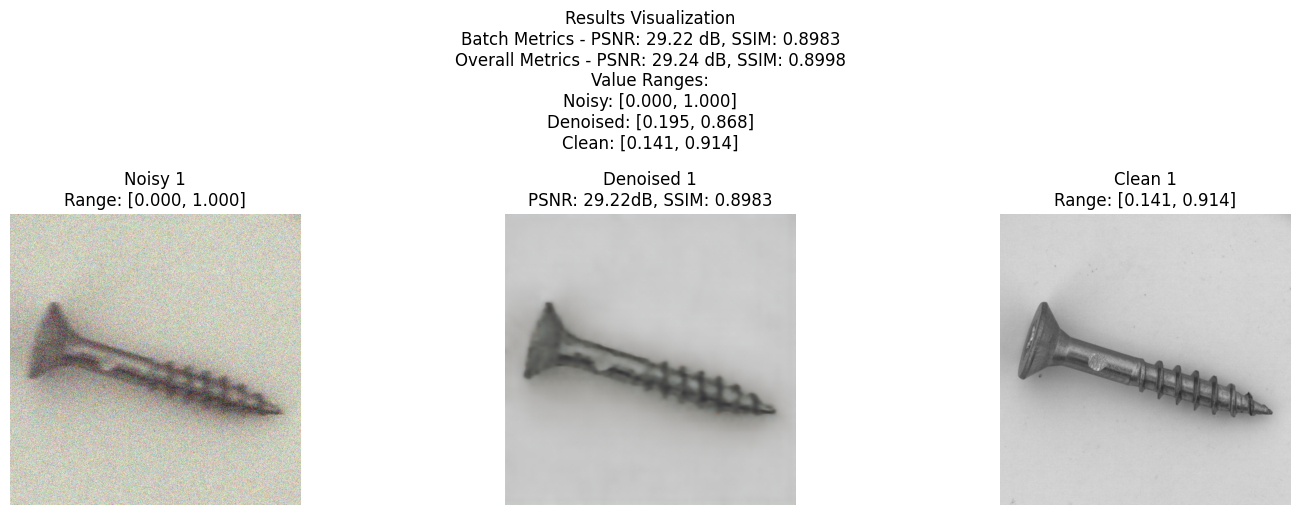


Final Evaluation Results:
Total images processed: 8
Average PSNR: 29.24 dB
Average SSIM: 0.8998
PSNR Standard Deviation: 2.20 dB
SSIM Standard Deviation: 0.0028
Starting full dataset evaluation...


KeyboardInterrupt: 

In [14]:
class_wise_metrics=dict()
os.makedirs('/kaggle/working/Test', exist_ok=True)

for subfolder in subfolders:
    os.makedirs(f"/kaggle/working/Test/{subfolder}", exist_ok=True)
    class_wise_metrics[subfolder]=test_restormer_with_display(
    model_1, model_2,
    class_loaders[subfolder], 
    device,
    display_interval=2  , output_dir=f'/kaggle/working/Test/{subfolder}'# Display results every 100 images
)


Batch 5, Total images processed: 6
Current Average PSNR: 35.96 dB
Current Average SSIM: 0.9649


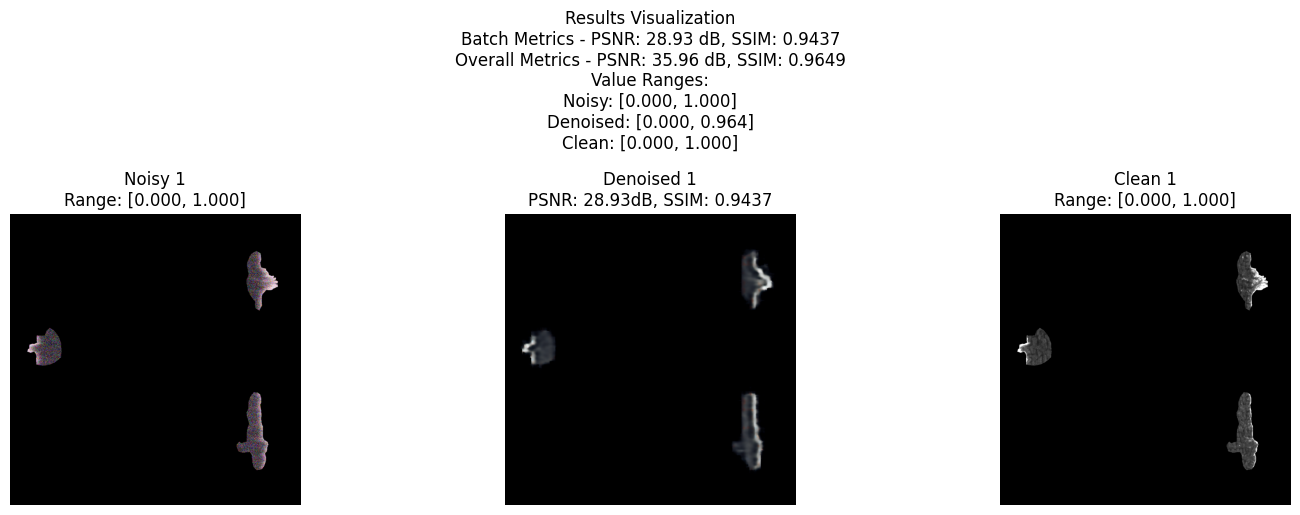


Final Evaluation Results:
Total images processed: 7
Average PSNR: 36.37 dB
Average SSIM: 0.9659
PSNR Standard Deviation: 4.42 dB
SSIM Standard Deviation: 0.0115


In [22]:
class_wise_metrics_defect=dict()
os.makedirs('/kaggle/working/Test_defect', exist_ok=True)

for subfolder in subfolders:
    os.makedirs(f"/kaggle/working/Test_defect/{subfolder}", exist_ok=True)
    class_wise_metrics_defect[subfolder]=test_restormer_with_display_defect(
    model_1, model_2,
    class_loaders[subfolder], 
    device,
    display_interval=2  , output_dir=f'/kaggle/working/Test_defect/{subfolder}'# Display results every 100 images
)

In [ ]:

psnr=[]
ssim=[]
for subfolder in subfolders:
    psnr.append(class_wise_metrics[subfolder]['psnr_avg'])
    ssim.append(class_wise_metrics[subfolder]['SSIM_avg'])
    print(f" The  PSNR values on the Test set  for class {subfolder}is :{class_wise_metrics[subfolder]['psnr_avg']}")
    print(f" The  SSIM values on the Test set for class {subfolder} is :{class_wise_metrics[subfolder]['SSIM_avg']}")

In [ ]:
psnr_overall=sum(psnr,[])
ssim_overall=sum(ssim,[])
print(f" The overall PSNR values on the Test set is :{np.mean(psnr_overall)}")
print(f" The overall SSIM values on the Test set is :{np.mean(ssim_overall)}")

In [ ]:
psnr_defect=[]
ssim_defect=[]
for subfolder in subfolders:
    psnr_defect.append(class_wise_metrics_defect[subfolder]['psnr_avg'])
    ssim_defect.append(class_wise_metrics_defect[subfolder]['SSIM_avg'])
    print(f" The  PSNR values on the Test set  for class {subfolder}is :{class_wise_metrics_defect[subfolder]['psnr_avg']}")
    print(f" The  SSIM values on the Test set for class {subfolder} is :{class_wise_metrics_defect[subfolder]['SSIM_avg']}")

In [ ]:
psnr_overall_defect=sum(psnr,[])
ssim_overall_defect=sum(ssim,[])
print(f" The overall PSNR values on the Test set is :{np.mean(psnr_overall_defect)}")
print(f" The overall SSIM values on the Test set is :{np.mean(ssim_overall_defect)}")

In [ ]:
"""plt.figure(figsize=(10, 6))
plt.bar(psnr, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('PSNR for each class')
plt.xticks(ticks=np.arange(len(subfolders)), labels=subfolders, rotation=45)
plt.tight_layout()  # Adjust layout to make room for x-axis labels
plt.show()"""


In [ ]:
"""plt.figure(figsize=(10, 6))
plt.bar(ssim, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('SSIM for each class')
plt.xticks(ticks=np.arange(len(subfolders)), labels=subfolders, rotation=45)
plt.tight_layout()  # Adjust layout to make room for x-axis labels
plt.show()"""